# Mixture Density Networks in GPflow

In this notebook we explain how to implement a Mixture Density Network (MDN) [1] using GPflow. In theory, this is similar to [this blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) from 2015, but instead of using TensorFlow directly we'll use GPflow. GPflow is typically used for building Gaussian Process-based models, but the framework contains many useful methods and classes that can be used to quickly prototype a wide variety of ML algorithms. Excellent for doing research!

We start by explaining why MDNs can be useful. We then examine a GPflow implementation of the model and use it for a couple of toy experiments.


## Conditional Density Estimation models
Imagine we are interested in performing regression on the following dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

CMAP = plt.get_cmap('Blues')

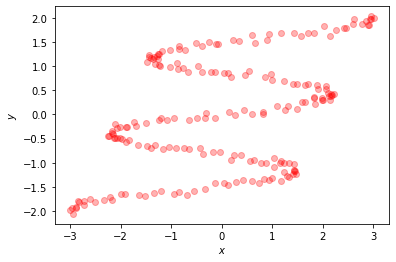

In [2]:
N = 200
NOISE_STD = 5.0e-2

def sinusoidal_data(N, noise):
    Y = np.linspace(-2, 2, N)[:, None]
    X = np.sin(4 * Y) * 2.0 + Y * 0.5
    X += np.random.randn(N, 1) * noise
    Y += np.random.randn(N, 1) * noise
    return X, Y

X, Y = data = sinusoidal_data(N, NOISE_STD)

plt.plot(X, Y,'ro', alpha=0.3);
plt.xlabel("$x$");
plt.ylabel("$y$");

At first sight, this dataset doesn't seem overly complex. Both input and output have a single dimension, and the data has a clear sinusoidal pattern. However, notice that a single input $x$ can correspond to multiple output values $y$, so for example $x=0$ can yield any of the values $\{-1.5, -3/4, 0, 0.8, 1.5\}$. Typical regression algorithms such as Linear Regression, Gaussian Process regression and Multilayer Perceptrons (MLPs) struggle as they can only predict one output value for every input.

To model this dataset we can use a Conditional Density Estimation (CDE) model. CDE models infer $p(f(x)|x)$ instead of just calculating the expectation $E[f(x) | x]$. Modeling the complete distribution $p(f(x)|x)$ is typically harder but it reveals more interesting properties, such as the modes, outlier boundaries and samples. A real-world example might be modeling taxi drop-offs, conditioned on the pick-up location. We would expect a taxi drop-off location to be multi-modal as passengers need to go to different destinations (airport/city center/suburbs and so on) and the density depends on the starting location [2]. 

## Mixture Density Network models

Mixture Density Networks (MDNs) are a parametric class of models that allow for conditional density estimation. They consist of two parts: a neural net and a Mixture of Gaussians (MoG). The neural net is responsible for producing the characteristics of the MoG. In practice, given that the MoG consists of $M$ Gaussians, the neural net will output a collection of $M$ means, variances and weights $\{\mu_m, \sigma_m^2, \pi_m\}_{m=1}^M$. These means, variances and weights are used to define the conditional probability distribution function: 
$$
p(Y = y\,|\,X = x) = \sum_{m=1}^{M} \pi_{m}(x)\,\mathcal{N}\big(y\, \left|\,\mu_{m}(x), \sigma_{m}^2(x)\big)\right.
$$

Each of the parameters  $\pi_{m}(x), \mu_{m}(x), \sigma_{m}(x)$ of the distribution are determined by the neural net, as a function of the input $x$.

We train the MDN's neural net by optimizing the model's likelihood:
$$
\mathcal{L} \triangleq \text{argmax}_{\Theta} \prod_{n=1}^N p(Y = y_n | X = x_n)
$$

where $\Theta$ collects the neural net's weights and biases and $\{x_n, y_n\}_{n=1}^N$ represents our training dataset.

## A GPflow MDN implementation

GPflow doesn't reinvent the wheel; most of what follows is just plain Python/TensorFlow code. We choose to use GPflow, however, because it provides us with functionality to easily define a model. Once we have a GPflow model, we can specify its objective function, parameters and dataset. This extra layer of abstraction makes interacting with the model much easier, for example optimizing or performing inference. 

We begin by importing the required packages from TensorFlow and GPflow.

In [3]:
import tensorflow as tf

In [4]:
import gpflow
from gpflow.models import BayesianModel
from gpflow.base import Parameter

Next, we create a `MDN` class that inherits from GPflow's `Model` class. We need to do the following:
1. Store each of the feature and target matrices (X, Y) as a `DataHolder` object.
2. Define our model's parameters using GPflow's `Parameter` and `ParamList` objects.
3. Define the objective function using the `_build_likelihood` method. When we optimize the model the negative of this function will be minimized. 

In [5]:
from typing import Callable, Optional, Tuple

class MDN(BayesianModel):
    
    def __init__(
        self, 
        num_mixtures: Optional[int] = 5,
        inner_dims: Optional[list] = [10, 10,],
        activation: Optional[Callable[[tf.Tensor], tf.Tensor]] = tf.keras.activations.relu
    ):
        super().__init__()

        # `self.dims` collects the neural net's input, hidden and output dimensions.
        # The number of output dims `self.dims[-1]` equals `num_mixtures` means +
        # `num _mixtures` variances + `num_mixtures` weights, a total of
        # 3 times `num_mixtures` variables.
        self.dims = [1, ] + list(inner_dims) + [3 * num_mixtures]
        self.activation = activation
        self._create_network()
        
    def _create_network(self):
        self.Ws, self.bs = [], []

        for dim_in, dim_out in zip(self.dims[:-1], self.dims[1:]):
            init_xavier_std = (2.0 / (dim_in + dim_out)) ** 0.5
            self.Ws.append(
                Parameter(np.random.randn(dim_in, dim_out) * init_xavier_std))
            self.bs.append(
                Parameter(np.zeros(dim_out)))

    def eval_network(self, X):
        for i, (W, b) in enumerate(zip(self.Ws,self.bs)):
            X = tf.matmul(X, W) + b
            if i < len(self.bs) - 1:
                X = self.activation(X)

        pis, mus, sigmas = tf.split(X, 3, axis=1)
        pis = tf.nn.softmax(pis)  # make sure they normalize to 1
        sigmas = tf.exp(sigmas)   # make sure std. dev. are positive
        
        return pis, mus, sigmas

    def log_marginal_likelihood(self, data: Tuple[tf.Tensor, tf.Tensor]):
        x, y = data
        pis, mus, sigmas = self.eval_network(x)
        Z = (2 * np.pi)**0.5 * sigmas
        log_probs_mog = (-0.5 * (mus - y)**2 / sigmas**2) - tf.math.log(Z) + tf.math.log(pis)
        log_probs = tf.reduce_logsumexp(log_probs_mog, axis=1)
        return tf.reduce_sum(log_probs)

### Notes
- Given we are dealing with a MoG, the neural net output must comply with the following restrictions:
$$
\sum_{m=1}^{M} \pi_{m}(x) = 1, \pi_m \ge 0\ \text{and}\ \sigma_m\ \forall\ m
$$
We achieve this by applying the `softmax` operator to the $\pi$'s and by taking the `exp` to the $\sigma$'s.

- We use the "Xavier" initialization for the neural net's weights. (Glorot and Bengio, 2010).

- Instead of calculating the pdf of the Gaussians, we work with the pdf `log` and use `tf.reduce_logsumexp`. This is mainly for numerical stability.

## Experiment 1: The sinusoidal dataset

Let's see how our model works in practice with the sinusoidal dataset presented earlier. We do this by initializing a new instance of our MDN model, and then specifying the dataset $(X, Y)$, the number of hidden units of the MDN's neural net, and the number of mixture components $M$.

In [6]:
model = MDN(inner_dims=[100, 100], num_mixtures=5)

from gpflow.utilities import print_summary
print_summary(model)

╒═══════════╤═══════════╤═════════════╤═════════╤═════════════╤════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name      │ class     │ transform   │ prior   │ trainable   │ shape      │ dtype   │ value                                                 │
╞═══════════╪═══════════╪═════════════╪═════════╪═════════════╪════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ MDN.Ws[0] │ Parameter │             │         │ True        │ (1, 100)   │ float64 │ [[4.24526768e-02, -1.18462982e-01, -2.38115047e-02... │
├───────────┼───────────┼─────────────┼─────────┼─────────────┼────────────┼─────────┼───────────────────────────────────────────────────────┤
│ MDN.Ws[1] │ Parameter │             │         │ True        │ (100, 100) │ float64 │ [[0.07092987, -0.02109097, -0.14236176...             │
├───────────┼───────────┼─────────────┼─────────┼─────────────┼────────────┼─────────┼───────────────────────────────────────────────────────┤

The objective function for MDN instances is the `log_marginal_likelihood`, which we use for optimization of the parameters. GPflow ensures that only the variables stored in `Parameter` objects are optimized. For the MDN, the only parameters are the weights and the biases of the neural net.

We use the `Scipy` optimizer, which is a wrapper around SciPy's L-BFGS optimization algorithm. Note that GPflow supports other TensorFlow optimizers such as `Adam`, `Adagrad`, and `Adadelta` as well.

In [7]:
from gpflow.optimizers import Scipy
from gpflow.ci_utils import ci_niter

Scipy().minimize(
    tf.function(lambda: - model.log_marginal_likelihood(data)),
    variables=model.trainable_parameters,
    options=dict(maxiter=ci_niter(1500))
);

print("Final Likelihood", model.log_marginal_likelihood(data).numpy())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'


Final Likelihood -296.4421727820326


To evaluate the validity of our model, we draw the posterior density. We also plot $\mu(x)$ of the optimized neural net. Remember that for every $x$ the neural net outputs $M$ means $\mu_m(x)$. These determine the location of the Gaussians. We plot all $M$ means and use their corresponding mixture weight $\pi_m(X)$ to determine their size. Larger dots will have more impact in the Gaussian ensemble. 

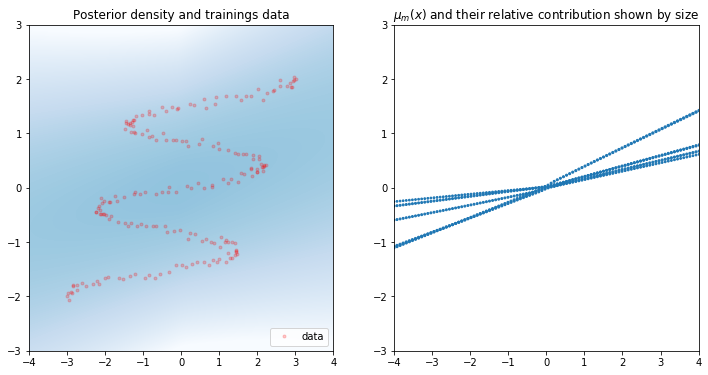

In [8]:
try:
    from mdn_plotting import plot
except:
    # VS CODE's root directory is GPflow's top-level directory
    from doc.source.notebooks.tailor.mdn_plotting import plot

fig, axes = plt.subplots(1, 2, figsize=(12,6))
for a in axes:
    a.set_xlim(-4, 4)
    a.set_ylim(-3, 3)
plot(model, X, Y, axes, cmap=CMAP)

## Experiment 2: The half moon dataset

The half moon dataset is available in the `scikit-learn` package.

In [9]:
from sklearn.datasets import make_moons

def moon_data(N, noise):
    data, _ = make_moons(n_samples=N, shuffle=True, noise=noise)
    X, Y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
    return X, Y

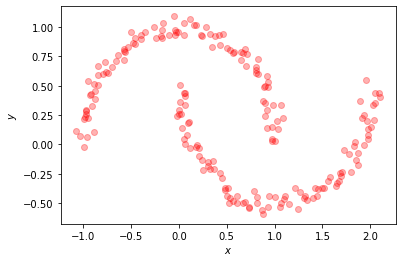

In [10]:
X, Y = data = moon_data(N, NOISE_STD)
plt.plot(X, Y, 'ro', alpha=0.3);
plt.xlabel("$x$");
plt.ylabel("$y$");

The only difference in the MDN's setup is that we lower the number of mixture components.

In [11]:
model = MDN(inner_dims=[100, 100], num_mixtures=5)

In [12]:
Scipy().minimize(
    tf.function(lambda: - model.log_marginal_likelihood(data)),
    variables=model.trainable_parameters,
    options=dict(maxiter=ci_niter(int(10e3)))
);

print("Final Likelihood", model.log_marginal_likelihood(data).numpy())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'


Final Likelihood -140.05826997563207


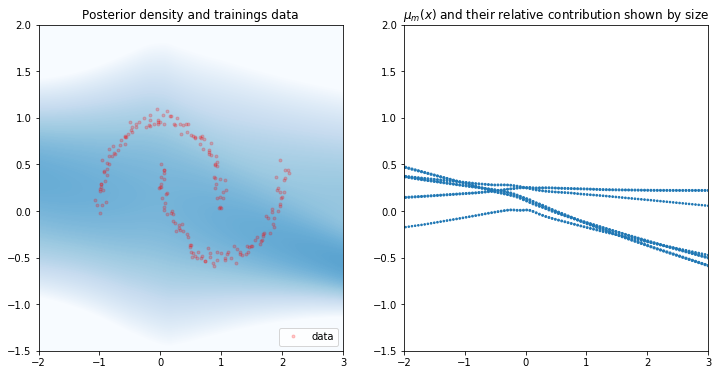

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for a in axes:
    a.set_xlim(-2, 3)
    a.set_ylim(-1.5, 2)
plot(model, X, Y, axes, cmap=CMAP)

## References

[1] Bishop, Christopher M. Mixture density networks. Technical Report NCRG/4288, Aston University, Birmingham, UK, 1994.

[2] Dutordoir, Vincent, et al. "Gaussian Process Conditional Density Estimation." Advances in Neural Information Processing Systems. 2018.